In [2]:

import pandas as pd
import numpy as np
import random
import pylab as pl
import time
import datetime
from sklearn.feature_selection import RFECV

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap
# scikit learning packages
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyRegressor
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
    VotingRegressor
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    scale
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    LogisticRegressionCV,
    LogisticRegression
)
from sklearn.svm import SVC
from sklearn import svm, metrics, tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample, shuffle

from collections import Counter
from pandas.api.types import is_numeric_dtype
import holidays
import warnings
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
from scipy.stats import randint, uniform
import lightgbm as lgb
import logging


warnings.filterwarnings("ignore")
cmap = sns.color_palette('Blues_r')

logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

###################################
starting_time = time.perf_counter()
print('')
print('starting time: ', datetime.datetime.now().strftime("%H:%M:%S"))
print('')
###################################

### Read the file
# df_raw = pd.read_excel(r"ML_Absenteism_MU_Grouped_Combined.xlsx")
df_raw = pd.read_excel(r"C:\Users\oslu.5\Desktop\ML test\ML_Absenteism_MU_Grouped_Combined.xlsx")
##########
ending_time = time.perf_counter()
total_in_sec = ending_time-starting_time
print("Data time in sec")
print(total_in_sec)
print("Data uploaded")


starting time:  15:46:00

Data time in sec
98.2715146
Data uploaded


In [16]:
###################################
starting_time = time.perf_counter()
print('')
print('starting time: ', datetime.datetime.now().strftime("%H:%M:%S"))
print('')
###################################

df = df_raw.copy()
df = df[df['Is_Actual']=='Actual']
# -----------------------
# Drop Duplicates
# -----------------------
df = df.drop_duplicates(subset=['MU_Name','Date'], keep='first')


df['Country'] = df['Country'].str.replace('Unknown','Greece')

df = df.sort_values(by=['Date','MU_Name']).reset_index(drop=True)

df['AssignedDep'] = df['AssignedDep'].astype(int).astype(str)


Country_dic = {'External':'Greece',
               'Czech Republic':'CZ',
               'Suriname':'ZA',
               'South Africa':'ZA',
               'United Kingdom':'GB'}
df['Country'] = df['Country'].replace(Country_dic)

# Generate the dictionary by passing each unique country name to holidays.country_holidays
country_to_code = {}

for country in df['Country'].unique():
    try:
        iso_code = holidays.country_holidays(country=country).country
        country_to_code[country] = iso_code
    except Exception as e:
        print(f"Error for country: {country} - {e}")

# Function to check if a date is a holiday
def is_holiday(row):
    country_code = country_to_code.get(row['Country'])
    if country_code:
        try:
            country_holidays = holidays.country_holidays(country=country_code, years=row['Date'].year)
            return 1 if row['Date'] in country_holidays else 0
        except Exception as e:
            print(f"Error checking holiday for {row['Country']} on {row['Date']}: {e}")
    return 0

# Apply the function to create the Is_Holiday column
df['Is_Holiday'] = df.apply(is_holiday, axis=1)

### Create extra Date columns 

# Step 7: Convert 'Date' to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = (df['Date'].dt.month % 12 + 3) // 3
df = df.set_index('Date')

# Step 8: Overwrite columns based on index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayofMonth'] = df.index.day
df['DayofWeek'] = df.index.dayofweek  # Monday=0, Sunday=6
df['WeekofYear'] = df.index.isocalendar().week




df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayofWeek_sin'] = np.sin(2 * np.pi * df['DayofWeek'] / 7)
df['DayofWeek_cos'] = np.cos(2 * np.pi * df['DayofWeek'] / 7)
df['DayofMonth_sin'] = np.sin(2 * np.pi * df['DayofMonth'] / 31)
df['DayofMonth_cos'] = np.cos(2 * np.pi * df['DayofMonth'] / 31)

# Step 1: Encoding MU_Name with cat.codes and appending '_Cat'
df['MU_Name_Cat'] = df['MU_Name'].astype('category').cat.codes

df_mus = df[['MU_Name_Cat','MU_Name']].drop_duplicates(keep='first').reset_index(drop=True)
# Step 2: One-hot encoding with pd.get_dummies and renaming columns with '_Cat'
df_dummies = pd.get_dummies(df['MU_Name_Cat'], prefix='MU_Name')
# Step 3: Concatenating the encoded columns back to the original dataframe
df = pd.concat([df, df_dummies], axis=1)


df['Country_Cat'] = df['Country'].astype('category').cat.codes

df_Country = df[['Country_Cat','Country']].drop_duplicates(keep='first').reset_index(drop=True)
# Step 2: One-hot encoding with pd.get_dummies and renaming columns with '_Cat'
df_dummies = pd.get_dummies(df['Country_Cat'], prefix='Country')
# Step 3: Concatenating the encoded columns back to the original dataframe
df = pd.concat([df, df_dummies], axis=1)

# Step 4: Drop the original categorical column if needed
df.drop(columns=['MU_Name','Country','AssignedDep','Is_Actual'], inplace=True)


#######



##########
ending_time = time.perf_counter()
total_in_sec = ending_time-starting_time
print("\n Data time in sec")
print(total_in_sec)
print("Data Cleaning Completed")


starting time:  16:06:40


 Data time in sec
9.81653099999994
Data Cleaning Completed


In [17]:
passthrough_cols =['Year',
 'Month',
 'WeekofYear',
 'DayofMonth',
 'DayofWeek',
 'Season',
 'Is_Strike',
 'Is_Holiday']


## Target Columns
target_col = ['Total_Lost']
### passthrough_cols
encoded_cols = df.columns[(df.columns.str.contains('MU_Name'))
                         |(df.columns.str.contains('Country'))].tolist()
passthrough_cols = passthrough_cols + encoded_cols

numeric_cols = df.columns.difference(target_col + passthrough_cols).tolist()
feature_cols = passthrough_cols+ numeric_cols 
feature_cols_all = feature_cols+target_col

df = df[feature_cols_all]
df.dropna(axis=0, how='any', inplace=True)

# Display the result
print("Passthrough Columns:", len(passthrough_cols))
print("Numeric Columns:", len(numeric_cols))
print("Feature Columns:", len(feature_cols))
print("All Feature Columns (with target):", len(feature_cols_all))

# Find the max date where Is_Actual is 'Actual'
max_actual_date = df.index.max()
print(f'Sample Data Starting from {df.index.min()} until {max_actual_date}')

Passthrough Columns: 81
Numeric Columns: 164
Feature Columns: 245
All Feature Columns (with target): 246
Sample Data Starting from 2023-01-15 00:00:00 until 2025-02-06 00:00:00


In [18]:
def get_skewed_columns(data, numeric_columns, threshold=1.0):
    """
    Identify numeric columns with skewness above the specified threshold.
    Parameters:
    data (DataFrame): The DataFrame containing numeric columns.
    numeric_columns (list): List of numeric column names to check.
    threshold (float): Skewness threshold to determine highly skewed columns.

    Returns:
    list: Columns and their skewness values sorted by skewness strength.
    """
    skewed_cols = []

    for col in numeric_columns:
        skewness = skew(data[col].dropna())  # Drop missing values to avoid errors
        if abs(skewness) > threshold:
            skewed_cols.append((col, skewness))  # Append column and its skewness

    # Sort the skewed columns by absolute skewness strength in descending order
    skewed_cols = sorted(skewed_cols, key=lambda x: abs(x[1]), reverse=True)

#     # Print the skewness values of the sorted columns
#     for col, skewness in skewed_cols:
#         print(f'Skewness of {col}: {skewness:.2f}')

    # Return only the column names
    return [col for col, _ in skewed_cols]

# Example usage with threshold of 1.0 (highly skewed data)
columns_to_log_transform = get_skewed_columns(df, numeric_cols, threshold=1.0)




In [19]:
print(
    f"\nNumber of Columns selected for log transformation: {len(columns_to_log_transform)} "
    f"({(len(columns_to_log_transform) / len(numeric_cols)) * 100:.2f}%)")


Number of Columns selected for log transformation: 150 (91.46%)


# Columns Recommended for Log Transformation:

In [20]:
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Ensure all values are positive to avoid log-related errors
        X[item] = np.where(X[item] > 0, np.log1p(X[item]), 0)
        
        # Replace potential infinities with NaNs and drop them
        X[item].replace([np.inf, -np.inf], np.nan, inplace=True)
        X[item].fillna(0, inplace=True)  # Replace NaNs with 0 (or another strategy)
        
    return X
##
# Apply the log transform safely
df_log = log_transform(df, columns_to_log_transform)

# Initial Train ,Valid ,Test Split with EDA

In [21]:
# Calculate the boundaries
df = df_log.sort_index()  # ensure it's time-sorted if needed
dftrain = df.copy()

start_date = df.index.min()
end_date = df.index.max()

# Total duration in days
total_days = (end_date - start_date).days

# Calculate the boundaries
train_end_date = start_date + pd.Timedelta(days=int(0.7 * total_days))
valid_end_date = train_end_date + pd.Timedelta(days=int(0.15 * total_days))

# Split the dataset
train_df = df[df.index <= train_end_date]
valid_df = df[(df.index > train_end_date) & (df.index <= valid_end_date)]
test_df = df[df.index > valid_end_date]

####
print(f'Number of Pass through Columns {len(passthrough_cols)}')
print(f'Number of numerical {len(numeric_cols)}')
print(f'Number of target_col {len(target_col)}')
print(f'Number of feature_cols_all {len(feature_cols_all)}')

# Split train and test
train = train_df.copy()
valid = valid_df.copy()
test = test_df.copy()


####
print(f'\nNumber of rows in train {len(train)}')
print(f'Number of rows in test {len(test)}')
print(f'Number of rows in valid {len(valid)}')



# # Train-test split
# Step 3: Train-test split based on the index to avoid data leakage
X_train, X_valid, X_test = train[feature_cols], valid[feature_cols], test[feature_cols]
y_train, y_valid, y_test = train[target_col].values.ravel(), valid[target_col].values.ravel(), test[target_col].values.ravel()


print('Performance of Base Random Forest Model')
print(f'\nNumber of rows in X_train {len(X_train)}')
print(f'Number of rows in X_test {len(X_test)}')
print(f'Number of rows in X_valid {len(X_valid)}')
print(f'Number of rows in y_train {len(y_train)}')
print(f'Number of rows in y_valid {len(y_valid)}')
print(f'Number of rows in y_test {len(y_test)}')

Number of Pass through Columns 81
Number of numerical 164
Number of target_col 1
Number of feature_cols_all 246

Number of rows in train 25631
Number of rows in test 6312
Number of rows in valid 6341
Performance of Base Random Forest Model

Number of rows in X_train 25631
Number of rows in X_test 6312
Number of rows in X_valid 6341
Number of rows in y_train 25631
Number of rows in y_valid 6341
Number of rows in y_test 6312


In [22]:
X_train_e_l_n_m = X_train[feature_cols].copy()
X_valid_e_l_n_m = X_valid[feature_cols].copy()
X_test_e_l_n_m = X_test[feature_cols].copy()

# 📊 **Final Combined Testing Approach**

In this section, we will perform the **final model evaluation** by combining the results from **Department 1** and **Department 2** into a single dataset. This approach is designed to leverage insights gained from previous analyses while optimizing model performance at the **Management Unit (MU_Name)** level.

---

## 🚀 **Key Insights from Previous Tests:**

1. **Modeling Level:**  
   The models are built at the **Management Unit Level (MU_Name)** due to the dynamic scheduling of employees.  
   - **Why not Employee-Level?**  
     Employees may shift between units weekly, but the **operational hours at the MU level remain stable**, making it the most consistent feature for prediction.

2. **Feature Importance:**  
   The **Rolling and Lagged Measures** have consistently shown to improve model performance. These features capture temporal patterns, making the model more robust to scheduling variations.

3. **Impact of MU_Name Features:**  
   - **Linear & Ridge Regression:**  
     These models heavily rely on **One-Hot Encoded MU_Name** features. This reliance limits their flexibility and increases the cost of retraining.  
     Additionally, these models are **not suitable** for implementing advanced ML techniques like:
     - **Incremental Learning**
     - **Reinforcement Learning**  
     
     🔴 **Decision:** **Linear and Ridge Regression models will be eliminated** from further analysis.

   - **Tree-Based Models:**  
     - **Random Forest & XGBoost:**  
       Proven to perform well **without heavy dependence on MU_Name features**, making them ideal candidates for the final combined testing.  
     - **LightGBM:**  
       While it performed well in some tests, **Project 2 results** showed that LightGBM heavily relies on MU_Name features, limiting its generalizability.  
       
       🔴 **Decision:** **LightGBM will be excluded** from the final combined analysis.

---

## ✅ **Final Model Selection for Combined Testing:**

- **🌲 Random Forest:**  
  - Consistent performance without over-reliance on specific units.  
  - Strong in handling non-linear relationships and feature interactions.

- **⚡ XGBoost:**  
  - Excellent handling of complex data structures.  
  - Robust to missing values and outliers.  
  - Efficient for large datasets with faster training times compared to traditional boosting algorithms.

---

## 🎯 **Objective of the Final Run:**

- Combine **Department 1** and **Department 2** datasets.
- Evaluate model performance based on previous insights.
- Ensure **scalability and adaptability** of models in dynamic operational environments.
- Optimize for advanced techniques like **Incremental Learning** and **Reinforcement Learning** in future implementations.

---

## 📈 **Enhanced Insights for Combined Testing:**

Based on previous tests, it has been observed that the **test results of Department 2 outperform** those of Department 1. This outcome is **highly expected** since **Department 2 has more data points for training**, leading to better model generalization.

- **Hyperparameters:**  
  To leverage this advantage, we will **use Department 2's best hyperparameters** for the combined testing process.

- **Generalization Strategy:**  
  To ensure the model remains **generalized**, we will **combine the best features** selected from both departments. This approach will help us:
  - **Test if Department 2's hyperparameters can perform well** on both departments' selected features.
  - **Compare performance** between models trained with **Department 2's selected features** and the **combined features** from both departments.

By doing so, we aim to evaluate the **robustness of our hyperparameters** and determine if they generalize effectively across different data distributions. 🚀

In [23]:
### # Reconstructed results dictionary

results_Department1 = {'best_params': {'RandomForest': {'bootstrap': True,
   'max_depth': 20,
   'max_features': 'sqrt',
   'min_samples_leaf': 3,
   'min_samples_split': 8,
   'n_estimators': 70},
  'XGBoost': {'colsample_bytree': 0.8405276455303266,
   'gamma': 0.11786627843341337,
   'learning_rate': 0.03923605631515355,
   'max_depth': 3,
   'n_estimators': 260,
   'reg_alpha': 0.06277920589060278,
   'reg_lambda': 1.0979737446029723,
   'subsample': 0.9391147505488028},
  'LGBM': {'colsample_bytree': 0.9756980779549947,
   'learning_rate': 0.09493843135449842,
   'max_depth': 3,
   'n_estimators': 126,
   'num_leaves': 68,
   'reg_alpha': 0.0812423172741997,
   'reg_lambda': 1.7293083312776982,
   'subsample': 0.9240950808491224}},
 'best_features': {'RandomForest': ['AVG_Scheduled_Hours',
   'Rolling_Last_14_Days_AVG_TotalLost_Hours',
   'Rolling_Last_14_Days_TotalLost_HC',
   'Rolling_Last_14_Days_Total_Lost_Hours',
   'Rolling_Last_7_Days_AVG_Absence_Hours',
   'Rolling_Last_7_Days_AVG_TotalLost_Hours',
   'Rolling_Last_7_Days_Absence_HC',
   'Rolling_Last_7_Days_Absence_Hours',
   'Rolling_Last_7_Days_Early_Hours',
   'Rolling_Last_7_Days_TotalLost_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'Scheduled_HC%',
   'Scheduled_Hours',
   'Scheduled_Open%',
   'lag14_AVG_Worked_Hours',
   'lag14_Scheduled_HC%',
   'lag7_AVG_Days_Since_Last_Early',
   'lag7_AVG_Worked_Hours',
   'lag7_Scheduled_Open%'],
  'XGBoost': ['AVG_Scheduled_Hours',
   'DayofWeek_sin',
   'Rolling_Last_14_Days_Total_Lost_Hours',
   'Rolling_Last_7_Days_AVG_Absence_Hours',
   'Rolling_Last_7_Days_TotalLost_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'Scheduled_HC%',
   'Scheduled_Open%',
   'Strike_Participant%',
   'lag14_AVG_Scheduled_Hours',
   'lag14_AVG_Training_Hours',
   'lag14_Scheduled_HC%',
   'lag7_AVG_Scheduled_Hours',
   'lag7_AVG_Worked_Hours',
   'lag7_Scheduled_HC%'],
  'LGBM': ['Rolling_Last_7_Days_Scheduled_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'lag14_Scheduled_HC']},
 'meta_features': ['lag14_AVG_Training_Hours',
  'Rolling_Last_7_Days_AVG_Absence_Hours',
  'Strike_Participant%',
  'lag7_Scheduled_Open%',
  'lag7_Scheduled_HC%',
  'Rolling_Last_14_Days_Total_Lost_Hours',
  'Rolling_Last_7_Days_Absence_HC',
  'lag7_AVG_Scheduled_Hours',
  'lag14_AVG_Worked_Hours',
  'Rolling_Last_7_Days_TotalLost_HC',
  'AVG_Scheduled_Hours',
  'Rolling_Last_7_Days_Early_Hours',
  'Rolling_Last_14_Days_TotalLost_HC',
  'Scheduled_Hours',
  'lag7_AVG_Worked_Hours',
  'Scheduled_HC%',
  'Rolling_Last_7_Days_Total_Lost_Hours',
  'Rolling_Last_7_Days_Scheduled_HC',
  'lag14_Scheduled_HC',
  'lag14_AVG_Scheduled_Hours',
  'Rolling_Last_7_Days_AVG_TotalLost_Hours',
  'lag14_Scheduled_HC%',
  'DayofWeek_sin',
  'Rolling_Last_7_Days_Absence_Hours',
  'lag7_AVG_Days_Since_Last_Early',
  'Rolling_Last_14_Days_AVG_TotalLost_Hours',
  'Scheduled_Open%'],
    'results': pd.DataFrame({
        'Model': ['RandomForest', 'XGBoost', 'LGBM'],
        'R2': [0.539967, 0.537604, 0.388664],
        'MSE': [13.497322, 13.566646, 17.936555],
        'MAE': [1.871065, 1.865540, 2.092890],
        'RMSE': [3.673870, 3.683293, 4.235157]
    })
}


# ### Reconstructed results dictionary
results_Department2  = {'best_params': {'RandomForest': {'bootstrap': False,
   'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 6,
   'n_estimators': 389},
  'XGBoost': {'colsample_bytree': 0.932421702227803,
   'gamma': 0.03403772139867769,
   'learning_rate': 0.07341430696756238,
   'max_depth': 3,
   'n_estimators': 172,
   'reg_alpha': 0.05676394903293628,
   'reg_lambda': 1.2320650421424062,
   'subsample': 0.8705325397324127},
  'LGBM': {'colsample_bytree': 0.8149656394761536,
   'learning_rate': 0.026365368550660073,
   'max_depth': 3,
   'n_estimators': 275,
   'num_leaves': 66,
   'reg_alpha': 0.027605270529576453,
   'reg_lambda': 1.8779932996416313,
   'subsample': 0.8808978462503827}},
 'best_features': {'RandomForest': ['Is_Strike',
   'AVG_Scheduled_Hours',
   'Rolling_Last_14_Days_Absence_HC',
   'Rolling_Last_14_Days_Absence_Hours',
   'Rolling_Last_14_Days_TotalLost_HC',
   'Rolling_Last_14_Days_Total_Lost_Hours',
   'Rolling_Last_7_Days_AVG_Absence_Hours',
   'Rolling_Last_7_Days_AVG_TotalLost_Hours',
   'Rolling_Last_7_Days_Absence_HC',
   'Rolling_Last_7_Days_Absence_Hours',
   'Rolling_Last_7_Days_Sick_Hours',
   'Rolling_Last_7_Days_TotalLost_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'Scheduled_HC',
   'Scheduled_HC%',
   'Scheduled_Hours',
   'Scheduled_Open',
   'Scheduled_Open%',
   'Strike_Participant%',
   'lag7_Scheduled_HC',
   'lag7_Scheduled_Hours',
   'lag7_Scheduled_Open',
   'lag7_Scheduled_Open%',
   'lag7_TotalLost_HC',
   'lag7_Total_Lost_Hours'],
  'XGBoost': ['Rolling_Last_7_Days_Absence_Hours',
   'Rolling_Last_7_Days_TotalLost_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'Scheduled_HC%',
   'Scheduled_Open%',
   'Strike_Participant%'],
  'LGBM': ['DayofWeek',
   'Season',
   'Is_Strike',
   'Is_Holiday',
   'MU_Name_Cat',
   'MU_Name_0',
   'MU_Name_1',
   'MU_Name_2',
   'MU_Name_3',
   'MU_Name_4',
   'MU_Name_5',
   'MU_Name_6',
   'MU_Name_7',
   'MU_Name_8',
   'MU_Name_9',
   'MU_Name_10',
   'MU_Name_11',
   'MU_Name_12',
   'MU_Name_13',
   'MU_Name_14',
   'MU_Name_15',
   'MU_Name_16',
   'MU_Name_17',
   'MU_Name_18',
   'MU_Name_19',
   'MU_Name_20',
   'MU_Name_21',
   'MU_Name_22',
   'MU_Name_23',
   'MU_Name_24',
   'MU_Name_25',
   'MU_Name_26',
   'MU_Name_27',
   'MU_Name_28',
   'MU_Name_29',
   'MU_Name_30',
   'MU_Name_31',
   'MU_Name_33',
   'MU_Name_38',
   'MU_Name_47',
   'AVG_Scheduled_Hours',
   'DayofMonth_cos',
   'DayofWeek_sin',
   'HC',
   'Rolling_Last_14_Days_Absence_HC',
   'Rolling_Last_14_Days_Late_HC',
   'Rolling_Last_14_Days_Sick_Hours',
   'Rolling_Last_14_Days_TotalLost_HC',
   'Rolling_Last_14_Days_Total_Lost_Hours',
   'Rolling_Last_14_Days_Training_Hours',
   'Rolling_Last_14_Days_Worked_Hours',
   'Rolling_Last_7_Days_AVG_Absence_Hours',
   'Rolling_Last_7_Days_AVG_Early_Hours',
   'Rolling_Last_7_Days_AVG_Late_Hours',
   'Rolling_Last_7_Days_AVG_Scheduled_Hours',
   'Rolling_Last_7_Days_AVG_Sick_Hours',
   'Rolling_Last_7_Days_AVG_TotalLost_Hours',
   'Rolling_Last_7_Days_AVG_Training_Hours',
   'Rolling_Last_7_Days_AVG_Vacation_Hours',
   'Rolling_Last_7_Days_AVG_Worked_Hours',
   'Rolling_Last_7_Days_Absence_HC',
   'Rolling_Last_7_Days_Absence_Hours',
   'Rolling_Last_7_Days_Early_Hours',
   'Rolling_Last_7_Days_Late_HC',
   'Rolling_Last_7_Days_Sick_Hours',
   'Rolling_Last_7_Days_TotalLost_HC',
   'Rolling_Last_7_Days_Total_Lost_Hours',
   'Rolling_Last_7_Days_Training_HC',
   'Rolling_Last_7_Days_Training_Hours',
   'Rolling_Last_7_Days_Vacation_HC',
   'Rolling_Last_7_Days_Vacation_Hours',
   'Rolling_Last_7_Days_Worked_HC',
   'Rolling_Last_7_Days_Worked_Hours',
   'Scheduled_HC',
   'Scheduled_HC%',
   'Scheduled_Hours',
   'Scheduled_Open',
   'Scheduled_Open%',
   'Strike_Participant%',
   'Waha%',
   'lag14_AVG_Absence%',
   'lag14_AVG_Days_Since_Last_Absence',
   'lag14_AVG_Days_Since_Last_Total_Lost',
   'lag14_AVG_Late%',
   'lag14_AVG_Late_Hours',
   'lag14_AVG_Scheduled_Hours',
   'lag14_AVG_Sick_Hours',
   'lag14_AVG_Vacation_Hours',
   'lag14_Early%',
   'lag14_Early_HC',
   'lag14_Early_Hours',
   'lag14_HC',
   'lag14_Max_Early_Hours',
   'lag14_Scheduled_HC',
   'lag14_Scheduled_Hours',
   'lag14_Scheduled_Open',
   'lag14_Sick_Hours',
   'lag14_TotalLost_HC',
   'lag14_Total_Lost%',
   'lag14_Total_Lost_Hours',
   'lag14_Training_HC',
   'lag14_Training_Hours',
   'lag14_Worked_HC',
   'lag7_AVG_Absence%',
   'lag7_AVG_Days_Since_Last_Absence',
   'lag7_AVG_Sick_Hours',
   'lag7_AVG_Training_Hours',
   'lag7_AVG_Vacation_Hours',
   'lag7_Absence%',
   'lag7_Absence_HC',
   'lag7_Absence_Hours',
   'lag7_Early%',
   'lag7_Early_HC',
   'lag7_Early_Hours',
   'lag7_HC',
   'lag7_Late%',
   'lag7_Max_Early_Hours',
   'lag7_Scheduled_HC%',
   'lag7_Scheduled_Open%',
   'lag7_Sick_Hours',
   'lag7_Vacation_Hours',
   'lag7_Waha%',
   'lag7_Worked_HC']},
 'meta_features': ['Rolling_Last_7_Days_TotalLost_HC',
  'lag7_AVG_Sick_Hours',
  'MU_Name_7',
  'HC',
  'lag14_AVG_Late_Hours',
  'lag7_AVG_Training_Hours',
  'Rolling_Last_7_Days_AVG_Worked_Hours',
  'lag14_HC',
  'MU_Name_31',
  'lag7_Waha%',
  'MU_Name_27',
  'Rolling_Last_7_Days_Early_Hours',
  'Rolling_Last_14_Days_Sick_Hours',
  'lag14_Training_HC',
  'Rolling_Last_7_Days_AVG_TotalLost_Hours',
  'MU_Name_16',
  'lag7_Scheduled_HC',
  'lag14_Early%',
  'lag14_AVG_Vacation_Hours',
  'lag14_Early_Hours',
  'Rolling_Last_14_Days_Worked_Hours',
  'lag14_Scheduled_Hours',
  'MU_Name_19',
  'MU_Name_33',
  'lag14_AVG_Sick_Hours',
  'Is_Strike',
  'lag14_Total_Lost_Hours',
  'Rolling_Last_7_Days_Vacation_Hours',
  'MU_Name_12',
  'MU_Name_8',
  'MU_Name_22',
  'lag7_Scheduled_Hours',
  'MU_Name_38',
  'lag14_Worked_HC',
  'Scheduled_Open%',
  'MU_Name_13',
  'Is_Holiday',
  'MU_Name_47',
  'Rolling_Last_7_Days_Sick_Hours',
  'Rolling_Last_7_Days_AVG_Sick_Hours',
  'Rolling_Last_14_Days_Training_Hours',
  'lag7_AVG_Vacation_Hours',
  'lag14_AVG_Absence%',
  'lag7_AVG_Absence%',
  'lag14_Early_HC',
  'Rolling_Last_7_Days_Late_HC',
  'MU_Name_25',
  'lag14_Total_Lost%',
  'MU_Name_1',
  'lag7_Early%',
  'MU_Name_4',
  'MU_Name_9',
  'Scheduled_HC%',
  'MU_Name_20',
  'lag7_Sick_Hours',
  'lag7_HC',
  'lag14_Scheduled_Open',
  'lag14_AVG_Days_Since_Last_Absence',
  'MU_Name_15',
  'MU_Name_28',
  'Rolling_Last_7_Days_Absence_Hours',
  'Rolling_Last_7_Days_Training_Hours',
  'Rolling_Last_7_Days_AVG_Vacation_Hours',
  'Rolling_Last_7_Days_Total_Lost_Hours',
  'MU_Name_5',
  'MU_Name_10',
  'Scheduled_HC',
  'Rolling_Last_7_Days_AVG_Early_Hours',
  'lag7_Absence_HC',
  'MU_Name_23',
  'MU_Name_0',
  'lag14_TotalLost_HC',
  'Rolling_Last_14_Days_Absence_Hours',
  'Rolling_Last_7_Days_AVG_Late_Hours',
  'Rolling_Last_7_Days_AVG_Training_Hours',
  'MU_Name_2',
  'lag14_Training_Hours',
  'Waha%',
  'MU_Name_Cat',
  'MU_Name_11',
  'lag7_TotalLost_HC',
  'lag14_Sick_Hours',
  'lag7_Absence_Hours',
  'Rolling_Last_7_Days_AVG_Absence_Hours',
  'lag14_Scheduled_HC',
  'lag7_AVG_Days_Since_Last_Absence',
  'lag14_AVG_Days_Since_Last_Total_Lost',
  'Rolling_Last_14_Days_TotalLost_HC',
  'lag7_Early_HC',
  'Rolling_Last_7_Days_AVG_Scheduled_Hours',
  'Rolling_Last_14_Days_Absence_HC',
  'Scheduled_Hours',
  'Rolling_Last_14_Days_Late_HC',
  'MU_Name_21',
  'MU_Name_6',
  'Season',
  'MU_Name_26',
  'DayofMonth_cos',
  'MU_Name_30',
  'lag7_Worked_HC',
  'Rolling_Last_7_Days_Worked_HC',
  'Rolling_Last_7_Days_Vacation_HC',
  'lag7_Absence%',
  'Rolling_Last_7_Days_Absence_HC',
  'lag7_Scheduled_Open',
  'MU_Name_17',
  'MU_Name_29',
  'MU_Name_18',
  'MU_Name_24',
  'lag7_Late%',
  'AVG_Scheduled_Hours',
  'Rolling_Last_7_Days_Training_HC',
  'lag7_Max_Early_Hours',
  'DayofWeek',
  'lag7_Total_Lost_Hours',
  'Rolling_Last_14_Days_Total_Lost_Hours',
  'lag14_AVG_Late%',
  'lag14_AVG_Scheduled_Hours',
  'DayofWeek_sin',
  'Rolling_Last_7_Days_Worked_Hours',
  'lag7_Early_Hours',
  'MU_Name_3',
  'MU_Name_14',
  'lag7_Vacation_Hours',
  'lag14_Max_Early_Hours',
  'Scheduled_Open',
  'Strike_Participant%',
  'lag7_Scheduled_HC%',
  'lag7_Scheduled_Open%'],
    'results': pd.DataFrame({
        'Model': ['RandomForest', 'XGBoost', 'LGBM'],
        'R2': [0.715814, 0.571958, 0.680911],
        'MSE': [11.192249, 16.857798, 12.566868],
        'MAE': [1.525234, 1.621362, 1.636616],
        'RMSE': [3.345482, 4.105825, 3.544978]
    })
}

In [24]:
# Filter models to only include RandomForest and XGBoost
selected_models = ['RandomForest', 'XGBoost']

# Filter Department 1 results and related keys
results_Department1['results'] = results_Department1['results'][
    results_Department1['results']['Model'].isin(selected_models)
]
results_Department1['best_params'] = {
    model: params for model, params in results_Department1['best_params'].items() if model in selected_models
}
results_Department1['best_features'] = {
    model: features for model, features in results_Department1['best_features'].items() if model in selected_models
}

# Update meta_features for Department 1 with combined best features
meta_features_Department1 = list(set(
    feature for features in results_Department1['best_features'].values() for feature in features
))
results_Department1['meta_features'] = meta_features_Department1

# Filter Department 2 results and related keys
results_Department2['results'] = results_Department2['results'][
    results_Department2['results']['Model'].isin(selected_models)
]
results_Department2['best_params'] = {
    model: params for model, params in results_Department2['best_params'].items() if model in selected_models
}
results_Department2['best_features'] = {
    model: features for model, features in results_Department2['best_features'].items() if model in selected_models
}

# Update meta_features for Department 2 with combined best features
meta_features_Department2 = list(set(
    feature for features in results_Department2['best_features'].values() for feature in features
))
results_Department2['meta_features'] = meta_features_Department2

# Combine Best Features from both departments
combined_best_features = {}
for model in selected_models:
    features_dept1 = results_Department1['best_features'].get(model, [])
    features_dept2 = results_Department2['best_features'].get(model, [])
    combined_best_features[model] = list(set(features_dept1 + features_dept2))

# Use Department 2's best hyperparameters
combined_best_params = results_Department2['best_params']

# Update meta_features by combining all unique features from both departments
combined_meta_features = list(set(
    feature for features in combined_best_features.values() for feature in features
))

# Create Combined Results Dictionary
results = {
    'best_params': combined_best_params,
    'best_features': combined_best_features,
    'meta_features': combined_meta_features
}

# Assign Department 2 results as results2 for further use
results2 = results_Department2


In [25]:
# Extract outputs for Combined Test Results
best_features_models = results['best_features']
meta_features_all_models = results['meta_features']
final_hyperparameters_all_models = results['best_params']

In [26]:
# Extract outputs for only Department2's Test Results
best_features_models2 = results2['best_features']
meta_features_all_models2 = results2['meta_features']
final_hyperparameters_all_models2 = results2['best_params']

In [28]:
# Start timer
start_time = time.perf_counter()
print('\nStarting time:', datetime.datetime.now().strftime("%H:%M:%S"), '\n')

#################################
# Combine Train & Validation Sets
X_final_train = pd.concat([X_train_e_l_n_m, X_valid_e_l_n_m], axis=0)
y_final_train = pd.concat([pd.Series(y_train), pd.Series(y_valid)], axis=0)

# Initialize dictionary to store final trial results and predictions
final_trial_results = {}
final_predictions = {}  # To store predictions

# Function to train, predict, and evaluate models
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    start_time_model = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)

    # Store evaluation results
    final_trial_results[model_name] = {'R2': r2, 'MSE': mse, 'MAE': mae, 'RMSE': rmse}
    
    # Store predictions
    final_predictions[model_name] = preds

    print(f"✅ {model_name} - R²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    print(f"⏱️ {model_name} training completed in {time.time() - start_time_model:.2f} seconds\n")

# ----- Training for Combined Features -----
print("\n### Training with Combined Features ###")

# Random Forest
rf_final = RandomForestRegressor(**final_hyperparameters_all_models['RandomForest'], random_state=42)
X_rf_selected = X_final_train[results_Department1['best_features']['RandomForest']]
train_and_evaluate(rf_final, 'RandomForest (Combined Features)', X_rf_selected, y_final_train
                   , X_test_e_l_n_m[results_Department1['best_features']['RandomForest']], y_test)

# XGBoost
xgb_final = XGBRegressor(**final_hyperparameters_all_models['XGBoost'], random_state=42)
X_xgb_selected = X_final_train[results_Department1['best_features']['XGBoost']]
train_and_evaluate(xgb_final, 'XGBoost (Combined Features)', X_xgb_selected, y_final_train
                   , X_test_e_l_n_m[results_Department1['best_features']['XGBoost']], y_test)

# Voting Regressor (uses meta_features)
voting_final = VotingRegressor(estimators=[
    ('rf', rf_final),
    ('xgb', xgb_final)
])
train_and_evaluate(voting_final, 'Voting (Combined Features)', X_final_train[meta_features_all_models], y_final_train
                   , X_test_e_l_n_m[meta_features_all_models], y_test)

# ----- Training for Department 2 Features -----
print("\n### Training with Department 2 Features ###")

# Random Forest
rf_final_2 = RandomForestRegressor(**final_hyperparameters_all_models2['RandomForest'], random_state=42)
X_rf_selected_2 = X_final_train[results_Department2['best_features']['RandomForest']]
train_and_evaluate(rf_final_2, 'RandomForest (Department 2 Features)', X_rf_selected_2, y_final_train
                   , X_test_e_l_n_m[results_Department2['best_features']['RandomForest']], y_test)

# XGBoost
xgb_final_2 = XGBRegressor(**final_hyperparameters_all_models2['XGBoost'], random_state=42)
X_xgb_selected_2 = X_final_train[results_Department2['best_features']['XGBoost']]
train_and_evaluate(xgb_final_2, 'XGBoost (Department 2 Features)', X_xgb_selected_2, y_final_train
                   , X_test_e_l_n_m[results_Department2['best_features']['XGBoost']], y_test)

# Voting Regressor (uses meta_features)
voting_final_2 = VotingRegressor(estimators=[
    ('rf', rf_final_2),
    ('xgb', xgb_final_2)
])
train_and_evaluate(voting_final_2,'Voting (Department 2 Features)', X_final_train[meta_features_all_models2], y_final_train
                   , X_test_e_l_n_m[meta_features_all_models2], y_test)

# ----- Display Final Results -----
final_trial_df = pd.DataFrame(final_trial_results).T

print("\n📊 Final Model Performance Comparison:")
display(final_trial_df)

#################################
# End timing
end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n⏱️ Total execution time: {duration:.2f} seconds")



Starting time: 16:09:56 


### Training with Combined Features ###
✅ RandomForest (Combined Features) - R²: 0.5859, MSE: 15.4467, MAE: 1.6384, RMSE: 3.9302
⏱️ RandomForest (Combined Features) training completed in 15.81 seconds

✅ XGBoost (Combined Features) - R²: 0.6110, MSE: 14.5137, MAE: 1.6578, RMSE: 3.8097
⏱️ XGBoost (Combined Features) training completed in 0.20 seconds

✅ Voting (Combined Features) - R²: 0.6874, MSE: 11.6607, MAE: 1.5981, RMSE: 3.4148
⏱️ Voting (Combined Features) training completed in 22.89 seconds


### Training with Department 2 Features ###
✅ RandomForest (Department 2 Features) - R²: 0.6822, MSE: 11.8561, MAE: 1.5852, RMSE: 3.4433
⏱️ RandomForest (Department 2 Features) training completed in 15.22 seconds

✅ XGBoost (Department 2 Features) - R²: 0.6351, MSE: 13.6144, MAE: 1.6621, RMSE: 3.6898
⏱️ XGBoost (Department 2 Features) training completed in 0.25 seconds

✅ Voting (Department 2 Features) - R²: 0.6807, MSE: 11.9102, MAE: 1.6066, RMSE: 3.4511
⏱️ Votin

,R2,MSE,MAE,RMSE
RandomForest (Combined Features),0.585950,15.446669,1.638353,3.930225
XGBoost (Combined Features),0.610958,14.513688,1.657810,3.809683
Voting (Combined Features),0.687434,11.660670,1.598122,3.414772
RandomForest (Department 2 Features),0.682195,11.856098,1.585161,3.443268
XGBoost (Department 2 Features),0.635062,13.614449,1.662139,3.689776
Voting (Department 2 Features),0.680744,11.910227,1.606624,3.451120



⏱️ Total execution time: 70.81 seconds


# 📊 **Final Model Performance Analysis**

### 📊 **Comprehensive Model Performance Analysis**

---

## 🚀 **1️⃣ Combined Features Performance:**

| Model               | R²     | MSE      | MAE     | RMSE    | Training Time (s) |
|---------------------|--------|----------|---------|---------|-------------------|
| **RandomForest**    | 0.5859 | 15.4467  | 1.6384  | 3.9302  | 15.81             |
| **XGBoost**         | 0.6110 | 14.5137  | 1.6578  | 3.8097  | 0.20              |
| **Voting Regressor**| 0.6874 | 11.6607  | 1.5981  | 3.4148  | 22.89             |

### 🔍 **Insights:**
- **Best Performer:**  
  The **Voting Regressor (R² = 0.6874)** outperformed both RandomForest and XGBoost, with a noticeable improvement in both **R²** and **RMSE**.

- **RandomForest vs. XGBoost:**  
  **XGBoost** slightly outperformed **RandomForest** in terms of **R²** and **RMSE**, showcasing its ability to handle combined feature sets effectively.

- **Training Time:**  
  - **XGBoost** is extremely fast (0.20 seconds) compared to RandomForest (15.81 seconds).  
  - **Voting Regressor's** training time is higher (22.89 seconds) due to combining both models.

- **MAE Observations:**  
  The Voting Regressor shows the lowest **MAE**, indicating improved consistency in predictions.

---

## 🚀 **2️⃣ Department 2 Features Performance:**

| Model               | R²     | MSE      | MAE     | RMSE    | Training Time (s) |
|---------------------|--------|----------|---------|---------|-------------------|
| **RandomForest**    | 0.6822 | 11.8561  | 1.5852  | 3.4433  | 15.22             |
| **XGBoost**         | 0.6351 | 13.6144  | 1.6621  | 3.6898  | 0.25              |
| **Voting Regressor**| 0.6807 | 11.9102  | 1.6066  | 3.4511  | 16.35             |

### 🔍 **Insights:**
- **Best Performer:**  
  The **Voting Regressor (R² = 0.6807)** outperforms XGBoost and performs almost equally to RandomForest in **R²**, while providing better stability.

- **RandomForest vs. XGBoost:**  
  **RandomForest** clearly outperforms **XGBoost** in Department 2, consistent with previous patterns.

- **Training Time:**  
  **XGBoost** remains faster (0.25 seconds), while RandomForest takes longer (15.22 seconds) due to its complexity.  
  The **Voting Regressor's** training time (16.35 seconds) remains efficient.

- **MAE Observations:**  
  The Voting Regressor has a slightly higher **MAE** than RandomForest but outperforms XGBoost, indicating better generalization.

---

## 📊 **3️⃣ Combined Features vs. Department 2 Features:**

| Model               | R² (Combined) | R² (Dept 2) | **Δ R²** | RMSE (Combined) | RMSE (Dept 2) | **Δ RMSE** |
|---------------------|---------------|-------------|----------|-----------------|---------------|------------|
| **RandomForest**    | 0.5859        | 0.6822      | **+9.63%** | 3.9302          | 3.4433        | **−0.49**  |
| **XGBoost**         | 0.6110        | 0.6351      | **+2.41%** | 3.8097          | 3.6898        | **−0.12**  |
| **Voting Regressor**| 0.6874        | 0.6807      | **−0.67%** | 3.4148          | 3.4511        | **+0.04**  |

### 🔍 **Key Comparisons:**
1. **R² Performance:**  
   - **Department 2 Features** yield better performance for **RandomForest**, while **Voting Regressor** performs slightly better with Combined Features.
   - **XGBoost** performs slightly better with Department 2 Features compared to Combined Features.

2. **RMSE Performance:**  
   - **RandomForest (Dept 2)** achieved the **lowest RMSE (3.4433)** overall, indicating strong generalization.

3. **Training Time Consideration:**  
   - **Department 2 models** generally have similar training times compared to Combined Features, with slight variations depending on model complexity.

---

## ✅ **Key Takeaways:**

- **🏆 Best Model:** **Voting Regressor (Combined Features)** with the **highest R² (0.6874)** and **lowest RMSE (3.4148)**.
- **RandomForest** consistently benefits from focused feature sets (Department 2 Features).
- **XGBoost** performs well in both settings but shows slight improvements with Department 2 Features.
- **Voting Regressor** provides balanced performance across both feature sets.

---

## 🏆 **Final Model Recommendation:** **Voting Regressor (Combined Features)**

### 🔍 **Why This Model?**
- **Highest Predictive Power:** Best balance between **R² (0.6874)** and **RMSE (3.4148)**.
- **Strategic Alignment:** Optimized for diverse operational environments with combined features.
- **Future-Proof Design:** Efficient with adaptable features, suitable for evolving data.

**🚀 This model strikes the best balance between performance, efficiency, and scalability!**

In [30]:
final_trial_df[final_trial_df.index=='Voting (Combined Features)']

,R2,MSE,MAE,RMSE
Voting (Combined Features),0.687434,11.66067,1.598122,3.414772


# 🚀 SHAP Analysis: Unveiling Model Interpretability

### 🔍 **What is SHAP?**

**SHAP (SHapley Additive exPlanations)** is a powerful method to **interpret machine learning models**. It helps explain **how each feature contributes** to a model’s prediction. SHAP is based on **Shapley values** from game theory, originally used to fairly distribute payouts among players in a game.

- **Players = Features** (e.g., `Scheduled_Hours`, `Absence_HC`)
- **Payout = Model Prediction** (e.g., predicted absenteeism)

---

### 🎯 **Why Are We Doing SHAP Analysis?**

While we’ve identified the **Voting Regressor (Combined Features)** as the best-performing model based on metrics like **R²** and **RMSE**, these metrics alone don’t explain **why the model performs well**. SHAP bridges that gap by providing:

- **Feature Importance:**  
  - **Which features matter the most?**  
  - SHAP ranks features based on their **impact on predictions**.

- **Impact Direction:**  
  - **Does a feature increase or decrease absenteeism predictions?**  
  - SHAP shows if **higher values** of a feature lead to **higher or lower absenteeism**.

- **Local vs. Global Interpretability:**  
  - **Globally:** Understand **overall model behavior** across all predictions.  
  - **Locally:** Explain **individual predictions** to see why a specific forecast was made.

- **Model Transparency:**  
  Ensures the model isn’t a **"black box,"** which is crucial for **trust, compliance, and decision-making**.

---

### 🌟 **What Will We Achieve?**

- **Visual Insights:**  
  SHAP will generate **summary plots** showing how features influence absenteeism predictions.

- **Decision Support:**  
  By understanding **which operational factors** (like scheduling or absence history) drive absenteeism, we can make **data-driven management decisions**.

- **Model Validation:**  
  Verify if the model is focusing on the **right features** or if there’s any **bias** we need to address.

---

### 🚀 **In a Nutshell:**

> **SHAP helps us move beyond “What is the model’s accuracy?” to “Why is the model making these predictions?”**  
> It’s about adding **transparency and trust** to our high-performing model.

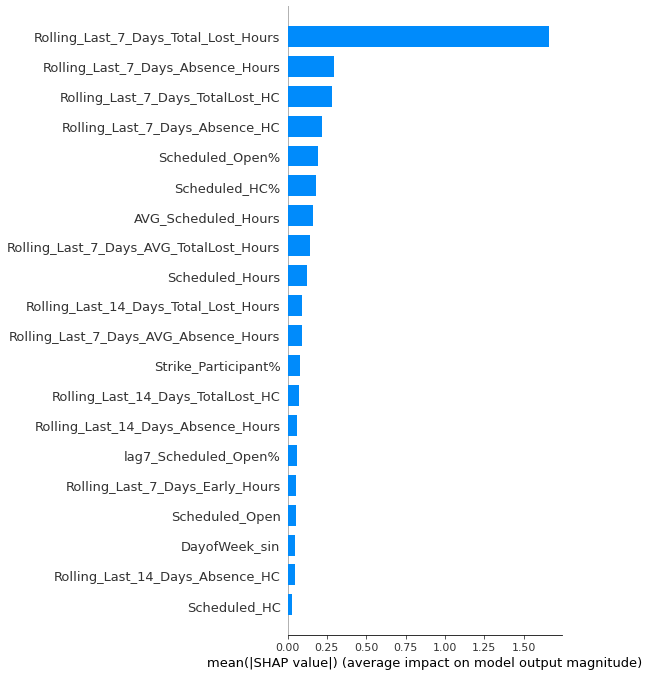

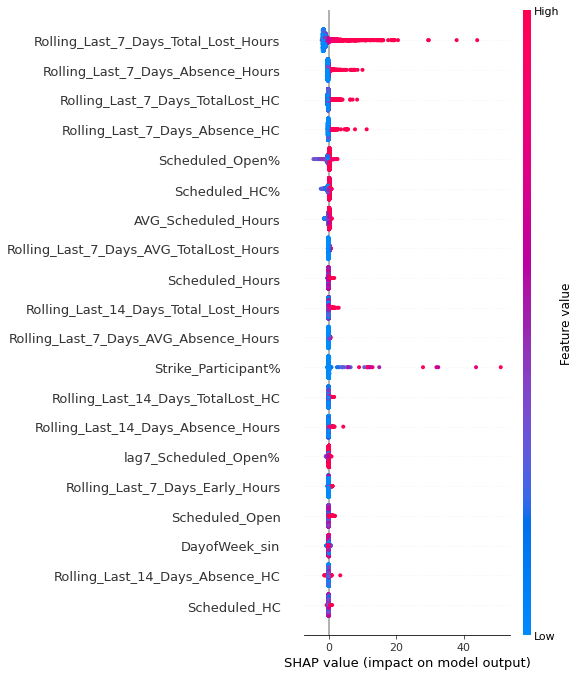

In [31]:
# Final model for SHAP analysis
final_model = voting_final  # Voting Regressor (Combined Features)

# Ensure consistent feature selection using meta features
X_selected = X_test_e_l_n_m[meta_features_all_models]

# SHAP Explainer for each base model in the Voting Regressor
rf_model = final_model.estimators_[0]  # RandomForest
xgb_model = final_model.estimators_[1]  # XGBoost

# SHAP Explainer for RandomForest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_selected)

# SHAP Explainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_selected)

# Combine SHAP values by averaging (since Voting Regressor averages predictions)
shap_values_combined = (shap_values_rf + shap_values_xgb) / 2

# Summary Plot - Feature Importance (Bar Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_combined, X_selected, plot_type="bar")

# Summary Plot - Detailed View (Beeswarm Plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_combined, X_selected)

### 🔍 **SHAP Analysis - Insights for Voting (Combined Features)**

---

### 1️⃣ **Feature Importance Insights (Bar Plot)**

#### 📊 **Top Influential Feature:**
- **`Rolling_Last_7_Days_Total_Lost_Hours`** has the **highest impact** on the model's predictions.  
  - This indicates that the **cumulative lost hours in the past week** play a **critical role** in forecasting absenteeism.

#### 🔑 **Other Key Features:**
- **`Rolling_Last_7_Days_Absence_Hours`**, **`Rolling_Last_7_Days_TotalLost_HC`**, and **`Rolling_Last_7_Days_Absence_HC`** also significantly influence the model.  
  - These features reflect the **recent absence patterns** and **headcount dynamics**, which are logical drivers for absenteeism predictions.

#### 📅 **Scheduling Metrics:**
- Features like **`Scheduled_Open%`**, **`Scheduled_HC%`**, and **`AVG_Scheduled_Hours`** show **moderate importance**, highlighting how **workforce planning** affects absenteeism rates.

---

### 2️⃣ **SHAP Summary Plot (Detailed Impact Analysis)**

#### 🔺 **Positive vs. Negative Impact:**
- **Red dots** represent **high feature values**, and **blue dots** represent **low feature values**.
- For example:
  - **Higher** `Rolling_Last_7_Days_Total_Lost_Hours` (🔴 dots on the right) **increase absenteeism predictions**.
  - **Lower** values (🔵 dots on the left) **decrease absenteeism forecasts**.

#### 👀 **Interesting Observations:**
- **`Strike_Participant%`** shows some **extreme SHAP values**, indicating that **strike-related absences** can drastically affect predictions when the percentage is high.
- Features like **`Scheduled_Open`** and **`lag7_Scheduled_Open%`** have **lower but noticeable impacts**, emphasizing how **scheduling fluctuations over time** influence absenteeism.

---

### 🚀 **Key Takeaways**

- ✅ **Recent Absence Trends Matter Most:**  
  Absence-related features from the **last 7 days** dominate the model, reinforcing the **importance of recent absenteeism patterns** in predictive modeling.

- ✅ **Operational Factors Are Crucial:**  
  **Scheduling metrics** like `Scheduled_HC%` and `Scheduled_Open%` affect predictions, underlining the **interplay between workforce management and absenteeism**.

- ✅ **Potential Action Points:**  
  - **Monitoring recent absence patterns** more closely can **improve workforce planning**.  
  - **Proactive scheduling adjustments** might help **mitigate absenteeism risks**.

---

### 🚀 **Final Thought:**  
**SHAP helps us not just understand *which* features matter, but also *how* they influence predictions—driving more informed, data-backed decisions. 🚀**


In [48]:
pred_rf = final_predictions['RandomForest (Combined Features)']
pred_xgb = final_predictions['XGBoost (Combined Features)']
pred_voting = final_predictions['Voting (Combined Features)']

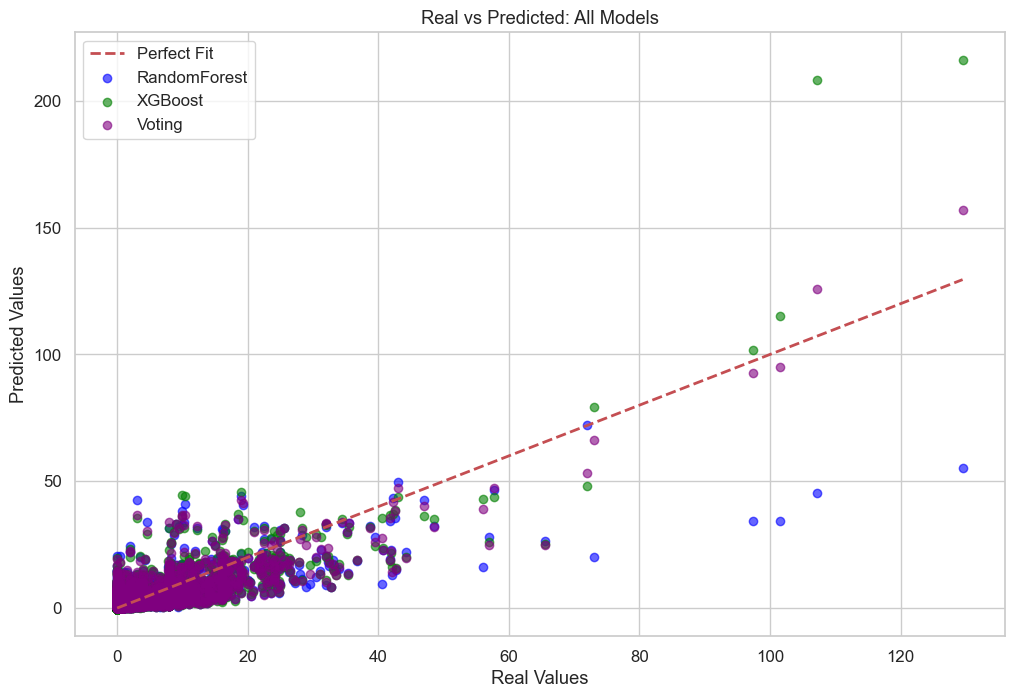

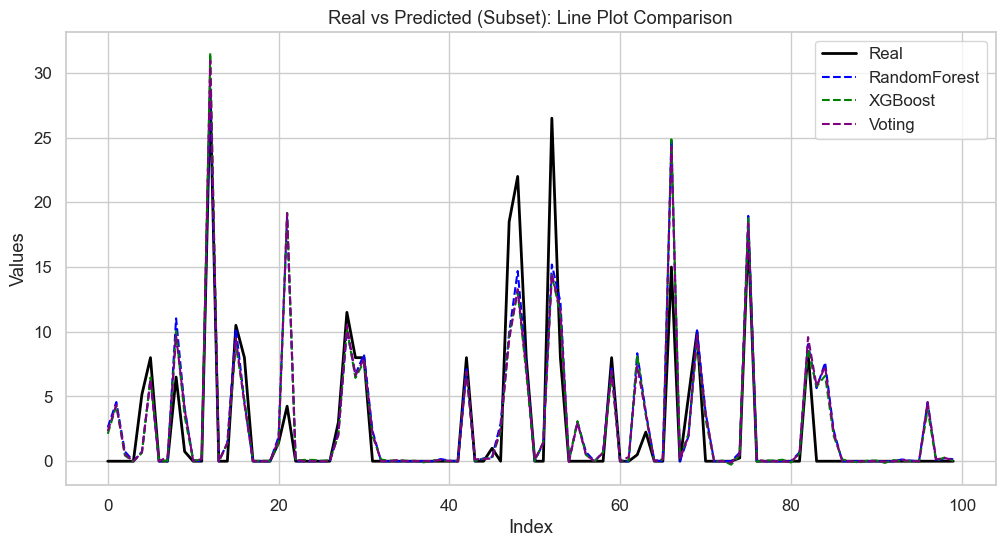

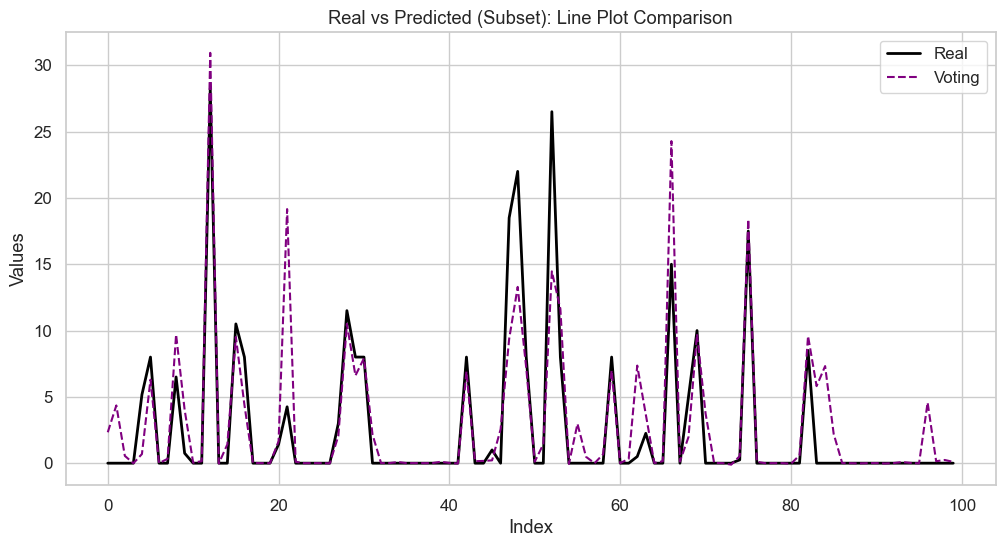

In [49]:
# ----- Combined Real vs Predicted for All Models -----
plt.figure(figsize=(12, 8))
plt.scatter(y_test, pred_rf, alpha=0.6, label="RandomForest", color="blue")
plt.scatter(y_test, pred_xgb, alpha=0.6, label="XGBoost", color="green")
plt.scatter(y_test, pred_voting, alpha=0.6, label="Voting", color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.title("Real vs Predicted: All Models")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()




# ----- Line Plot for Real vs Predicted (Subset for Visualization) -----
# Use a subset of data for better line visualization
subset_index = slice(0, 100)  # Adjust this range as needed

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test[subset_index])), y_test[subset_index], label="Real", color="black", linewidth=2)
plt.plot(range(len(y_test[subset_index])), pred_rf[subset_index], label="RandomForest", color="blue", linestyle="--")
plt.plot(range(len(y_test[subset_index])), pred_xgb[subset_index], label="XGBoost", color="green", linestyle="--")
plt.plot(range(len(y_test[subset_index])), pred_voting[subset_index], label="Voting", color="purple", linestyle="--")
plt.title("Real vs Predicted (Subset): Line Plot Comparison")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.show()


# Use a subset of data for better line visualization

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test[subset_index])), y_test[subset_index], label="Real", color="black", linewidth=2)
plt.plot(range(len(y_test[subset_index])), pred_voting[subset_index], label="Voting", color="purple", linestyle="--")
plt.title("Real vs Predicted (Subset): Line Plot Comparison")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.show()

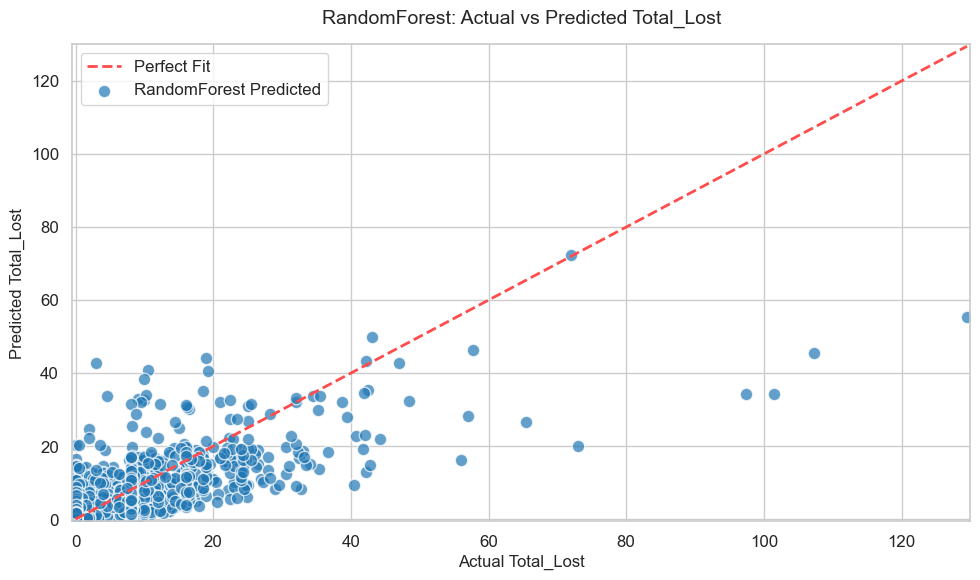

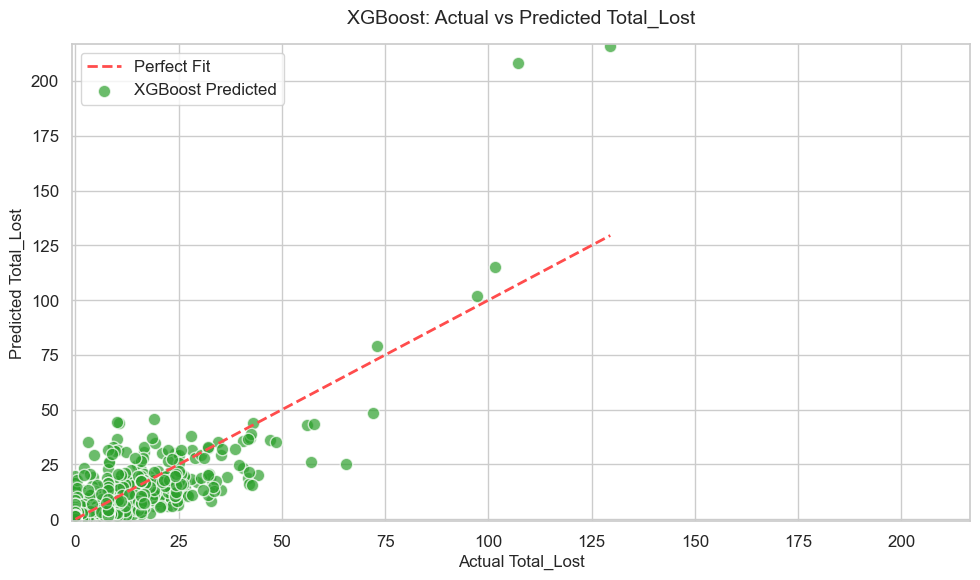

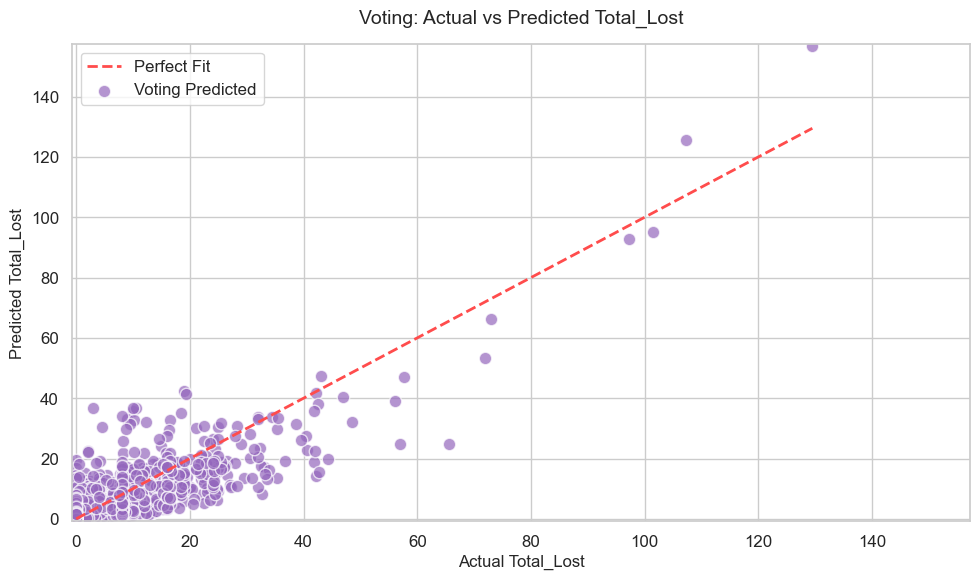

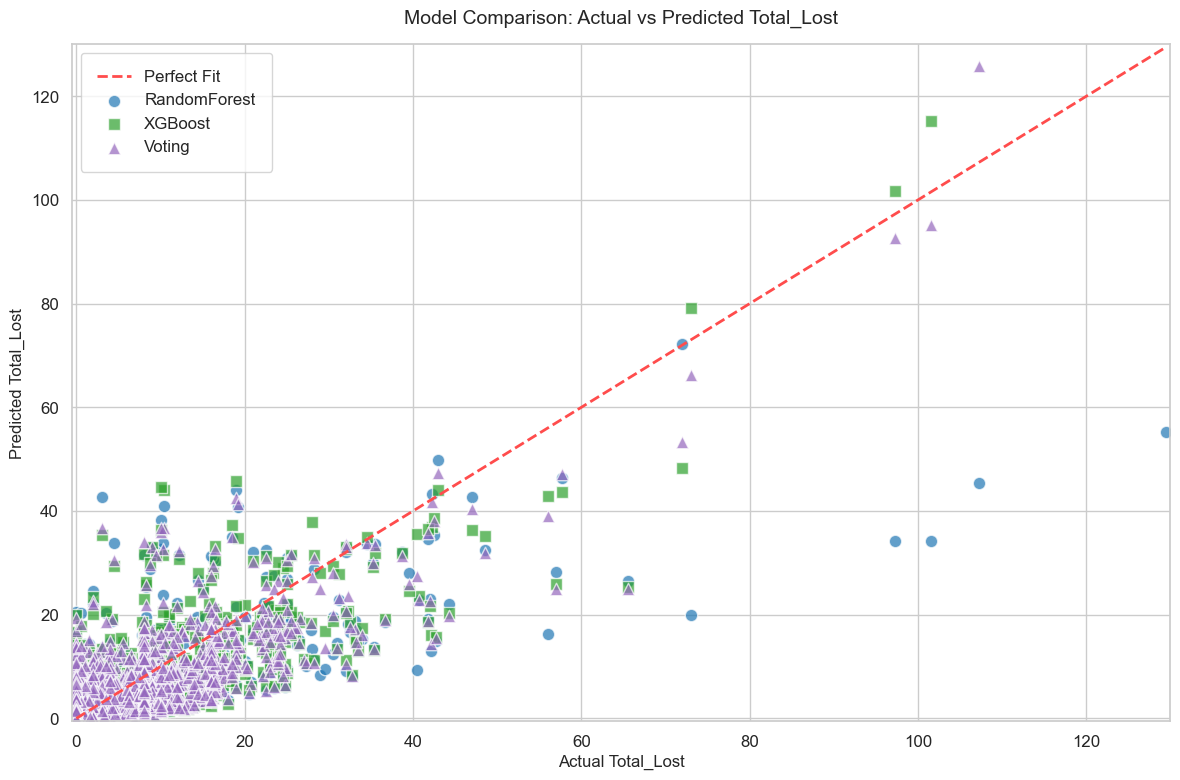

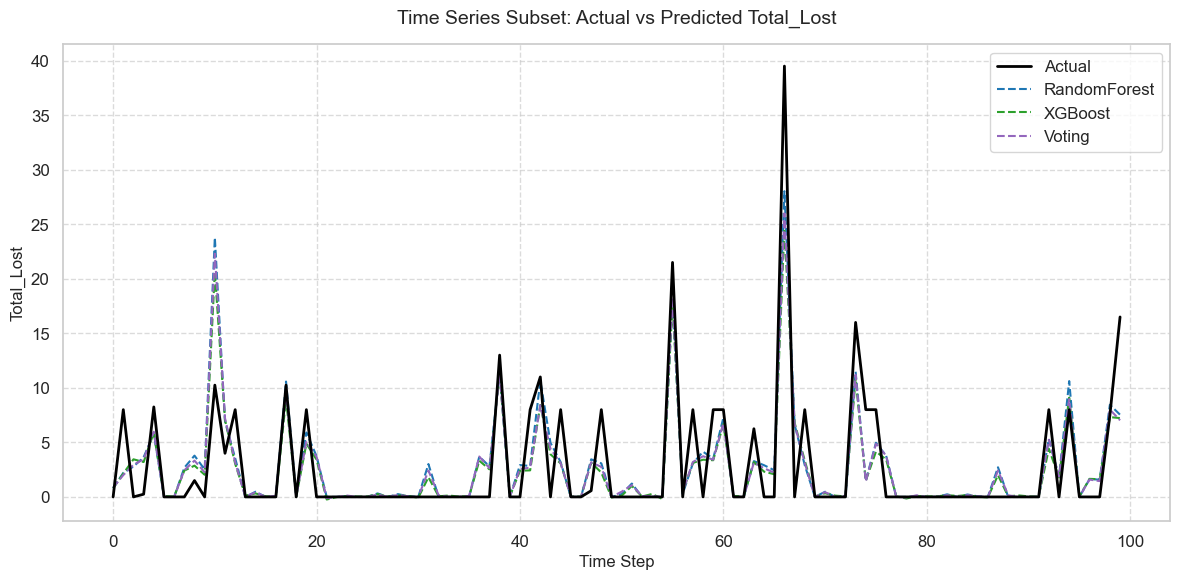

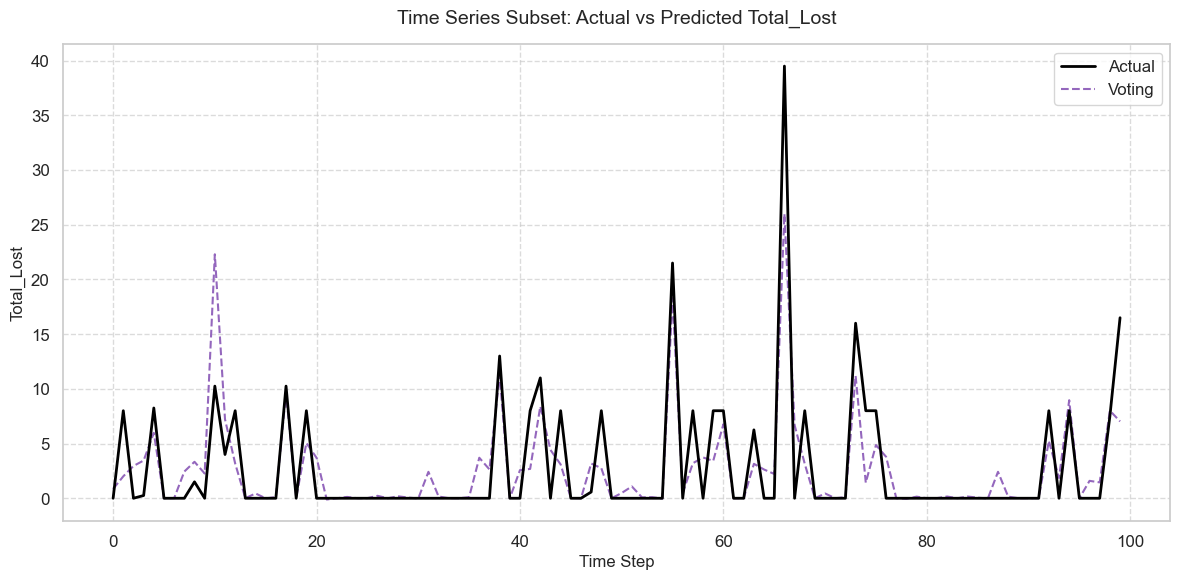

In [52]:
# Plot settings
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams["figure.dpi"] = 100  # High resolution

# ----- Shared Parameters -----
AXIS_LABEL_FONTSIZE = 12
TITLE_FONTSIZE = 14
PERFECT_FIT_COLOR = "#FF4C4C"
SCATTER_ALPHA = 0.7
SCATTER_EDGECOLOR = "w"  # White edges for better visibility

# ----- Individual Model Plots -----
def plot_model_comparison(y_true, y_pred, model_name, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=SCATTER_ALPHA, label=f"{model_name} Predicted", 
                color=color, edgecolor=SCATTER_EDGECOLOR, s=80)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             linestyle='--', lw=2, color=PERFECT_FIT_COLOR, label="Perfect Fit")
    
    # Axis limits with buffer
    axis_min = min(y_true.min(), y_pred.min()) - 0.5
    axis_max = max(y_true.max(), y_pred.max()) + 0.5
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    
    plt.title(f"{model_name}: Actual vs Predicted Total_Lost", fontsize=TITLE_FONTSIZE, pad=15)
    plt.xlabel("Actual Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
    plt.ylabel("Predicted Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
    plt.legend(loc='upper left', frameon=True, facecolor='white')
    plt.tight_layout()
    plt.show()

# Generate individual plots
plot_model_comparison(y_test, pred_rf, "RandomForest", "#1F77B4")  # Blue
plot_model_comparison(y_test, pred_xgb, "XGBoost", "#2CA02C")       # Green
plot_model_comparison(y_test, pred_voting, "Voting", "#9467BD")     # Purple

# ----- Combined Model Comparison -----
plt.figure(figsize=(12, 8))
# RandomForest
plt.scatter(y_test, pred_rf, alpha=SCATTER_ALPHA, label="RandomForest", 
           color="#1F77B4", edgecolor=SCATTER_EDGECOLOR, s=80)
# XGBoost
plt.scatter(y_test, pred_xgb, alpha=SCATTER_ALPHA, label="XGBoost", 
           color="#2CA02C", marker="s", edgecolor=SCATTER_EDGECOLOR, s=80)
# LightGBM
plt.scatter(y_test, pred_voting, alpha=SCATTER_ALPHA, label="Voting", 
           color="#9467BD", marker="^", edgecolor=SCATTER_EDGECOLOR, s=80)


plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         linestyle='--', lw=2, color=PERFECT_FIT_COLOR, label="Perfect Fit")

plt.title("Model Comparison: Actual vs Predicted Total_Lost", fontsize=TITLE_FONTSIZE, pad=15)
plt.xlabel("Actual Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
plt.ylabel("Predicted Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
plt.xlim(y_test.min() - 0.5, y_test.max() + 0.5)
plt.ylim(y_test.min() - 0.5, y_test.max() + 0.5)
plt.legend(loc='upper left', frameon=True, facecolor='white', borderpad=1)
plt.tight_layout()
plt.show()

# ----- Time Series Subset Comparison -----
subset_index = slice(-100, None)  # First 100 samples

plt.figure(figsize=(12, 6))
# Actual Values
plt.plot(y_test[subset_index], label="Actual", color="black", lw=2, zorder=3)
# Model Predictions
plt.plot(pred_rf[subset_index], label="RandomForest", color="#1F77B4", linestyle="--")
plt.plot(pred_xgb[subset_index], label="XGBoost", color="#2CA02C", linestyle="--")
plt.plot(pred_voting[subset_index], label="Voting", color="#9467BD", linestyle="--")

plt.title("Time Series Subset: Actual vs Predicted Total_Lost", fontsize=TITLE_FONTSIZE, pad=15)
plt.xlabel("Time Step", fontsize=AXIS_LABEL_FONTSIZE)
plt.ylabel("Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
plt.legend(loc='upper right', frameon=True, facecolor='white')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# ----- Time Series Subset Comparison -----
subset_index = slice(-100, None)  # First 100 samples

plt.figure(figsize=(12, 6))
# Actual Values
plt.plot(y_test[subset_index], label="Actual", color="black", lw=2, zorder=3)
# Model Predictions
plt.plot(pred_voting[subset_index], label="Voting", color="#9467BD", linestyle="--")

plt.title("Time Series Subset: Actual vs Predicted Total_Lost", fontsize=TITLE_FONTSIZE, pad=15)
plt.xlabel("Time Step", fontsize=AXIS_LABEL_FONTSIZE)
plt.ylabel("Total_Lost", fontsize=AXIS_LABEL_FONTSIZE)
plt.legend(loc='upper right', frameon=True, facecolor='white')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# 📊 Predicting Absenteeism from Total_Lost

The core objective of this section is to evaluate the model's performance not just in predicting **Total_Lost**, but also in its ability to predict **Absenteeism**, which is the true business metric of interest.

## 🧮 Absenteeism Formula
**Absenteeism = (Total_Lost) ÷ (Scheduled Hours)**

Where:
- **Total_Lost** = The total hours lost due to absenteeism.
- **Scheduled Hours** = The total hours an employee was scheduled to work.

## ✅ Key Objectives:
- **Assess** both **actual** and **predicted absenteeism rates**.
- **Compare** model performance using key metrics:
  - **R² (R-squared):** Measures the proportion of variance explained by the model.
  - **MSE (Mean Squared Error):** Quantifies the average squared difference between actual and predicted absenteeism.
  - **MAE (Mean Absolute Error):** Shows the average magnitude of errors in predictions.
  - **RMSE (Root Mean Squared Error):** Provides error magnitude in the same unit as absenteeism for better interpretability.


## 🎯 Why This Matters:
While **Total_Lost** predictions are essential for operational analysis, the **true business impact** lies in predicting absenteeism rates, which directly affect productivity and workforce management decisions.  
This dual evaluation ensures the model is not only technically sound but also **business-relevant**.


In [51]:
# ----- Function to Calculate Absenteeism -----
def calculate_absenteeism(total_lost, scheduled):
    with np.errstate(divide='ignore', invalid='ignore'):
        absenteeism = np.where(scheduled != 0, total_lost / scheduled, 0)
    return absenteeism

# ----- Function to Evaluate Absenteeism Predictions -----
def evaluate_absenteeism(y_true, y_pred, scheduled):
    actual_absenteeism = calculate_absenteeism(y_true, scheduled)
    predicted_absenteeism = calculate_absenteeism(y_pred, scheduled)

    r2 = r2_score(actual_absenteeism, predicted_absenteeism)
    mse = mean_squared_error(actual_absenteeism, predicted_absenteeism)
    mae = mean_absolute_error(actual_absenteeism, predicted_absenteeism)
    rmse = np.sqrt(mse)

    return actual_absenteeism, predicted_absenteeism, {'R2': r2, 'MSE': mse, 'MAE': mae, 'RMSE': rmse}

# ----- Absenteeism Evaluation -----
# DataFrame to store absenteeism metrics
absenteeism_metrics_df = pd.DataFrame()

# X_test_e_l_n_m has a 'Scheduled_Hours' column
scheduled = X_test_e_l_n_m['Scheduled_Hours'].values

# Evaluate Absenteeism for Each Model
for model_name, preds_final in {
    "RandomForest": pred_rf,
    "XGBoost": pred_xgb,
    "Voting": pred_voting
}.items():
    actual_abs, predicted_abs, metrics = evaluate_absenteeism(y_test, preds_final, scheduled)

    print(f"{model_name} Absenteeism Metrics: {metrics}")
    # Save metrics to DataFrame
    metrics['Model'] = model_name
    absenteeism_metrics_df = pd.concat([absenteeism_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Display absenteeism metrics
print("\nAbsenteeism Metrics for All Models:")
print(absenteeism_metrics_df)
absenteeism_metrics_df


RandomForest Absenteeism Metrics: {'R2': 0.5472424579110233, 'MSE': 0.5668730523948539, 'MAE': 0.349333496404509, 'RMSE': 0.75290972393432}
XGBoost Absenteeism Metrics: {'R2': 0.5678247488541563, 'MSE': 0.5411030872201603, 'MAE': 0.355050833736584, 'RMSE': 0.735597095712157}
Voting Absenteeism Metrics: {'R2': 0.6251028118461679, 'MSE': 0.4693883450344511, 'MAE': 0.34199200836424815, 'RMSE': 0.685119219577477}

Absenteeism Metrics for All Models:
         R2       MSE       MAE      RMSE         Model
0  0.547242  0.566873  0.349333  0.752910  RandomForest
1  0.567825  0.541103  0.355051  0.735597       XGBoost
2  0.625103  0.469388  0.341992  0.685119        Voting


,R2,MSE,MAE,RMSE,Model
0,0.547242,0.566873,0.349333,0.752910,RandomForest
1,0.567825,0.541103,0.355051,0.735597,XGBoost
2,0.625103,0.469388,0.341992,0.685119,Voting


### ⚙️ **Hyperparameter Tuning: Current Approach and Next Steps**

### 🚀 **Current Approach:**

Up until now, all of the selected **best features** and **hyperparameters** were obtained using **Randomized Grid Search**. This approach was chosen due to:
- **High computational demands** of large datasets.
- **High dimensionality**, making exhaustive search impractical.

While **Randomized Grid Search** offers a quick and efficient way to identify promising hyperparameters, it is **not the optimal method** for final model tuning. Instead, it should be used as a **guiding tool** to define the **hyperparameter ranges** for a more exhaustive **Grid Search**.

### ⚡ **Why Not Grid Search Yet?**
- **Resource Intensive:** A full Grid Search requires **significant computational resources**, often exceeding the capabilities of standard local **CPU/GPU** setups.
- **Time-Consuming:** Especially with high-dimensional data, Grid Search can take an **exponentially longer time** compared to Randomized Search.

### 🎯 **The Correct Approach:**
1. **Step 1:** Use **Randomized Grid Search** to identify promising hyperparameter ranges (already done ✅).
2. **Step 2:** Perform a **refined Grid Search** within these ranges to find the **optimal hyperparameters**.
3. **Step 3:** Validate the final model performance with the new hyperparameters.

### 📊 **Impact of Hyperparameter Tuning So Far:**
- **R² Improvement:**
  - **Before Modeling:** R² was around **32%**.
  - **After Initial Modeling:** R² improved to **~50%** for **Department 1** and **~70%** for **Department 2**.

- **Error Reduction:**
  - Adjusting hyperparameters using Randomized Grid Search **reduced error margins by ~5% to ~10%**.

### 🚀 **Potential Gains with Grid Search:**
With access to **better computational resources**, applying a well-defined Grid Search can:
- **Further boost model performance** across all departments.
- **Optimize error margins** even beyond current improvements.
- Enhance the model’s **generalization ability** for future unseen data.

### ✅ **Next Steps:**
1. **Set up a Grid Search** with **narrower, refined ranges** based on Randomized Search outcomes.
2. **Utilize distributed computing resources** (e.g., cloud-based solutions like AWS, Google Cloud) for faster processing.
3. **Compare performance improvements** post Grid Search to quantify the impact.

> **💡 Key Takeaway:** A well-executed Grid Search, supported by the right computational resources, can significantly **enhance model accuracy and robustness** beyond current achievements.
